# Tutorial for human gastrula dataset

## CIARA functions
Install the ciara_python package over pip (can of course also be done in command line)

In [3]:
import sys
!{sys.executable} -m pip install --upgrade ciara_python

Import the two important CIARA functions and other packages needed for this notebook.

In [4]:
import scanpy as sc
import pandas as pd
import time
import numpy as np

from ciara_python import get_background_full, ciara

## Import human gastrula dataset and KNN matrix

Note that for Anndata object the count matrix is transposed (cells x genes) compared to the Seurat pipeline in R (genes x cells).

In [6]:
human_gast_norm = sc.read_csv('../Data/norm_elmir_5_30_transposed.csv', delimiter=',')
#change to your data path

human_gast_norm = human_gast_norm.transpose()
print(human_gast_norm)

AnnData object with n_obs × n_vars = 1195 × 36570


Calculate the PCA and from this the knn matrix for the dataset using the integrated scanpy function.

In [7]:
#sc.pp.highly_variable_genes(human_gast_norm, n_top_genes=2000)
sc.tl.pca(human_gast_norm, n_comps=30)
sc.pp.neighbors(human_gast_norm, n_neighbors=5, use_rep='X_pca')
print(human_gast_norm.obsp["connectivities"].shape)

/Users/marco.stock/opt/anaconda3/envs/scanpy/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(1195, 1195)


## CIARA algorithm

### Step 1: Find background genes

The background genes get calculated and added as boolean values to the gene metadata in the AnnData object (in column `human_gast_norm.var["CIARA_background"]`):

In [8]:
t = time.perf_counter()

get_background_full(human_gast_norm, threshold=1, n_cells_low=3, n_cells_high=20)

elapsed_time = time.perf_counter() - t
print("Execution time: " + str(np.round(elapsed_time, 2)) + "s")

Background genes: 5057
Execution time: 0.08s


### Step 2: Calculate entropy of mixing of background genes

The p value for each background gene is added to the gene metadata in the AnnData object (in column `human_gast_norm.var["CIARA_p_value"]`):

**Runtime (4-core MacBook Pro) per size of genes (no approximation):**
- 1 gene: **0.2s**
- 10 genes: **0.5s**
- 100 genes: **4s**
- 1000 genes: **10s**
- 5057 genes *(this dataset)*: **270s**

In [9]:
t = time.perf_counter()

ciara(human_gast_norm, n_cores=4, p_value=0.001, approximation=True, local_region=1)

elapsed_time = time.perf_counter() - t
print("\nExecution Time: " + str(np.round(elapsed_time, 2)) + "s")


## Running on 4 cores with a chunksize of 317

---- Finished sucessfully! ----

Execution Time: 17.07s


## Ciara results

We receive an extended AnnData object that contains the results in its gene metadata:


In [10]:
human_gast_norm.var

,CIARA_p_value,CIARA_background
A1BG,NaN,False
A1BG.AS1,NaN,False
A1CF,0.000442,True
A2M,NaN,False
A2M.AS1,NaN,False
...,...,...
ZXDC,0.000488,True
ZYG11A,NaN,False
ZYG11B,NaN,False
ZYX,NaN,False


We can now plot the top genes with lowest p-value on the UMAP of the dataset. For this we extract the top rare cell type marker genes identified by CIARA:

In [11]:
top_markers = human_gast_norm.var.nsmallest(4, ["CIARA_p_value"],)
top_markers

,CIARA_p_value,CIARA_background
STAB2,6.390857e-11,True
GIMAP4,2.638277e-09,True
ECM1,2.164534e-08,True
OIT3,2.859037e-08,True


Now we plot the expression of the top markers in the umap to identify the rare cells. Of course, by defining a threshold on these top markers we can then also subset the scanpy dataset to extract the rare cells.

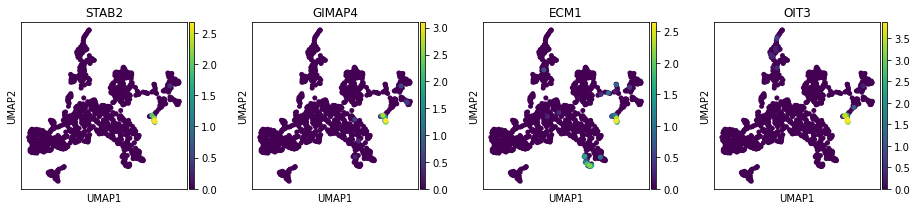

In [12]:
from matplotlib.pyplot import rc_context

sc.tl.umap(human_gast_norm)

with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(human_gast_norm, color=top_markers.index.tolist())